# CPSC479/579 Assignment 2: Colorizing Photos
Publish date: Jan 27, 2025

Sergei Mikhailovich Prokudin-GorskiiLinks. (1863-1944) was a photographer ahead of his time. He saw color photography as the wave of the future and came up with a simple idea to produce color photos: record three exposures of every scene onto a glass plate using a red, a green, and a blue filter and then project the monochrome pictures with correctly coloured light to reproduce the color image; color printing of photos was difficult at the time. Due to the fame he received from his color photos, including the only color portrait of Leo Tolstoy. (a famous Russian author), he won the Tzar's permission and funding to travel across the Russian Empire and document it in color photographs. His RGB glass plate negatives were purchased in 1948 by the Library of Congress. They are now digitized and available on-line.


## Overview

The goal of this assignment is to take the digitized Prokudin-Gorskii glass plate images and, using image processing techniques, automatically produce a color image with as few visual artifacts as possible. In order to do this, you will need to extract the three color channel images, place them on top of each other, and align them so that they form a single RGB color image. [This](http://www.loc.gov/exhibits/empire/making.html) is a cool explanation on how the Library of Congress composed their color images.

We will assume that a simple x,y translation model is sufficient for proper alignment. However, the full-size glass plate images (i.e. `.tif` files) are very large, so your alignment procedure will need to be relatively fast and efficient. When you begin your naive implementation, you should start with the smaller files (`.jpg` files) provided, or by downsizing the larger files. Your submission should be run on the full-size images (i.e. `.tif` images).

Your program will take a glass plate image as input and produce a single color image as output. The program should divide the image into three equal parts and align the second and the third parts (e.x. G and R) to the first (B). For each image, you will need to print the (x,y) displacement vector that was used to align the parts.

original image shape: (9693, 3719)


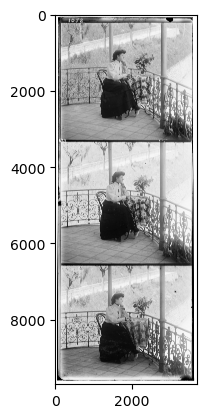

In [115]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# name of the input file
# image_path = './example_images/1.tif'       # don't always experiment with original size images
image_path = './example_images/3.tif'

# read in the image
full_image = Image.open(image_path)

# convert to numpy array and normalize to float (scale 0 to 1)
full_image = np.asarray(full_image) / 255.0

print(f'original image shape: {full_image.shape}')
plt.imshow(full_image, cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.007843137254902..257.0].


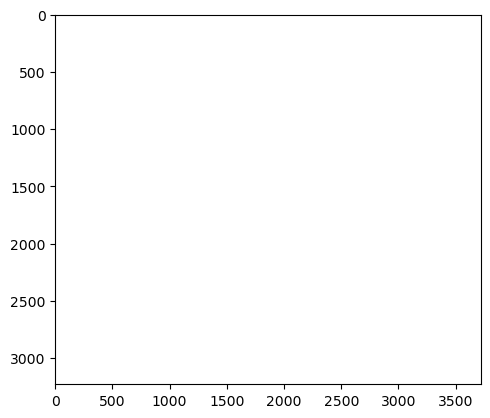

In [116]:
# compute the height of each part (just 1/3 of total)
height = full_image.shape[0] // 3

# separate color channels
B = full_image[0:height]
G = full_image[height:height*2]
R = full_image[height*2:height*3]

# create a color image (3D array)
color_image = np.stack([R, G, B], axis=-1)

plt.imshow(color_image)
plt.show()

In [117]:
# convert array back to an Image
color_image = Image.fromarray((color_image * 255).astype(np.uint8))

# display the resulting image
color_image.show()

# save result image
color_image.save('./output.jpg')

The easiest way to align the parts is to exhaustively search over a window of possible displacements (say `[-15,15]` pixels), score each one using some image matching metric, and take the displacement with the best score. There is a number of possible metrics that one could use to score how well the images match. The simplest one is just the L2 norm also known as the Euclidean Distance which is simply `sqrt(sum(sum((image1-image2).^2)))` where the sum is taken over the pixel values. Another is Normalized Cross-Correlation (NCC), which is simply a dot product between two normalized vectors: `(image1./||image1|| and image2./||image2||)`.

Exhaustive search will become prohibitively expensive if the pixel displacement is too large (which will be the case for high-resolution glass plate scans). In this case, you will need to implement a faster search procedure such as an image pyramid. An image pyramid represents the image at multiple scales (usually scaled by a factor of 2) and the processing is done sequentially starting from the coarsest scale (smallest image) and going down the pyramid, updating your estimate as you go. It is very easy to implement by adding recursive calls to your original single-scale implementation. Do not use MATLAB's impyramid function but you can use imresize.

Your job will be to implement an algorithm that, given a 3-channel image, produces a color image as output. Implement a simple single-scale version first, using for loops, searching over a user-specified window of displacements. The above directory has skeleton Python/MATLAB code that will help you get started and you should pick one of the smaller `.jpg` images in the directory to test this version of the code. Next, add a coarse-to-fine pyramid speedup to handle large images like the `.tif` ones provided in the directory.

In [118]:
# Complete your alignment code here

sobel_kernel = np.array([[-1, 0, 1]
                        ,[-2, 0, 2]
                        ,[-1, 0, 1]])

def apply_convolution2D(image_array, kernel):
    """
    Apply Gaussian blur to an image using NumPy.
    :param image_array: Input image as a NumPy array
    :param kernel_size: Size of the Gaussian kernel (should be odd)
    :param sigma: Standard deviation of the Gaussian kernel
    :return: Blurred image as a NumPy array
    """
    kernel_size = len(kernel)
    other_kernel = kernel.T
    padding = kernel_size // 2

    print(padding)

    # Pad the image to handle edges
    padded_image = np.pad(image_array,
                          ((padding, padding), (padding, padding)),
                          mode='edge')

    # Initialize the output image
    blurred_image = np.zeros_like(image_array, dtype=np.float64)

    # Convolution operation
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
                region = padded_image[i:i + kernel_size, j:j + kernel_size]
                sum = np.sqrt(pow(np.sum(region * kernel), 2) + pow(np.sum(region * other_kernel), 2))
                blurred_image[i, j] = sum
                # blurred_image[i, j, 1] = 255

    return np.clip(blurred_image, 0, 1).astype(np.uint)

1
1
1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


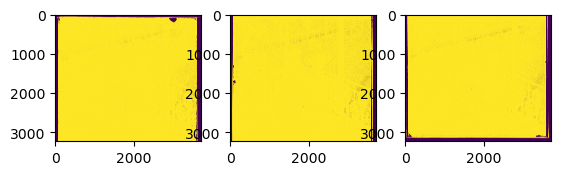

In [119]:
# Find image edges, and compare image equality?
B_edges = apply_convolution2D(B, sobel_kernel)
G_edges = apply_convolution2D(G, sobel_kernel)
R_edges = apply_convolution2D(R, sobel_kernel)

print(G_edges)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(B_edges)
ax2.imshow(G_edges)
ax3.imshow(R_edges)

plt.show()

In [120]:
def forceAlignImage(im2, xDisplacement, yDisplacement):
    new_img = None
    if yDisplacement > 0:
        new_img = np.pad(im2, ((yDisplacement, 0), (0, 0)), mode='constant')[:-yDisplacement, :]
    else:
        new_img = np.pad(im2, ((0, -yDisplacement), (0, 0)), mode='constant')[-yDisplacement:, :]

    if xDisplacement > 0:
        new_img = np.pad(new_img, ((0, 0), (xDisplacement, 0)), mode='constant')[:, :-xDisplacement]
    else:
        new_img = np.pad(new_img, ((0, 0), (0, -xDisplacement)), mode='constant')[:, -xDisplacement:]
    
    return new_img

In [121]:
# Sample random points across the image, and find the images that matches the best
def sample_distance(image1: np.array, image2: np.array, xdisplacement, ydisplacement):
    assert(image1.shape == image2.shape)
    padded_image_2 = forceAlignImage(image2, xdisplacement, ydisplacement)
    distance = np.sqrt(np.sum(np.power(image1 - padded_image_2, 2)))
    return distance

sample_distance(B_edges, G_edges, 10, 60)

598.1931126316986

In [122]:
def alignImages(im1_edges, im2, im2_edges, max_displacement):
    best_img = None
    best_score = float('inf')
    best_disp = None

    # Find alignment
    for xDist in range(-max_displacement, max_displacement):
        for yDist in range(-max_displacement, max_displacement):
            img = forceAlignImage(im2, xDist, yDist)
            score = sample_distance(im1_edges, im2_edges, xDist, yDist)
            if score < best_score:
                best_score = score
                best_img = img
                best_disp = (xDist, yDist)
        
    print(best_score, "at alignment", best_disp)
    print(best_img)
    return best_img

In [123]:
new_G = alignImages(B_edges, G, G_edges, 45)
new_R = alignImages(B_edges, R, R_edges, 45)

634.0118295426356 at alignment (15, 44)
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 257. 257. 257.]
 [  0.   0.   0. ... 257. 257. 257.]
 [  0.   0.   0. ... 257. 257. 257.]]
735.5487747253746 at alignment (29, 44)
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 257. 257. 257.]
 [  0.   0.   0. ... 257. 257. 257.]
 [  0.   0.   0. ... 257. 257. 257.]]


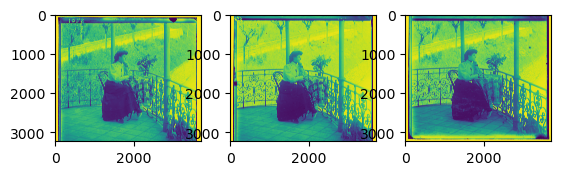

In [124]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(B)
ax1.imshow(new_G)
ax2.imshow(new_R)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..257.0].


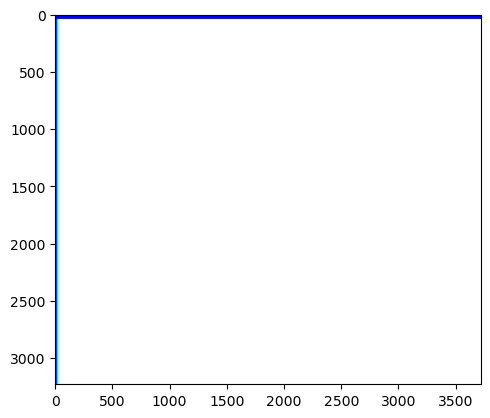

In [125]:
aligned_Image = np.stack([new_R, new_G, B], axis=-1)
plt.imshow(aligned_Image)

In [126]:
# convert array back to an Image
a_image = Image.fromarray((aligned_Image * 255).astype(np.uint8))

# display the resulting image
a_image.show()

# save result image
a_image.save('./aligned.jpg')

## Bells & Whistles (Extra Credit)

Although the color images resulting from this automatic procedure will often look strikingly real, they are still a far cry from the manually restored versions available on the LoC website and from other professional photographers. Of course, each such photograph takes days of painstaking Photoshop work, adjusting the color levels, removing the blemishes, adding contrast, etc. Can we make some of these adjustments automatically, without the human in the loop? Feel free to come up with your own approaches or talk to me about your ideas. There is no right answer here -- just try out things and see what works. For example, the borders of the photograph will have strange colors since the three channels won't exactly align. See if you can devise an automatic way of cropping the border to get rid of the bad stuff. One possible idea is that the information in the good parts of the image generally agrees across the color channels, whereas at borders it does not.

Here are some ideas, but we will give credit for other clever ideas:

* Automatic cropping. Remove white, black or other color borders. Don't just crop a predefined margin off of each side -- actually try to detect the borders or the edge between the border and the image.

* Automatic contrasting. It is usually safe to rescale image intensities such that the darkest pixel is zero (on its darkest color channel) and the brightest pixel is 1 (on its brightest color channel). More drastic or non-linear mappings may improve perceived image quality.

* Automatic white balance. This involves two problems -- 1) estimating the illuminant and 2) manipulating the colors to counteract the illuminant and simulate a neutral illuminant. Step 1 is difficult in general, while step 2 is simple (see the Wikipedia page on [Color Balance](http://en.wikipedia.org/wiki/Color_balance). and section 2.3.2 in the [Szeliski book](https://szeliski.org/Book/).). There exist some simple algorithms for step 1, which don't necessarily work well -- assume that the average color or the brightest color is the illuminant and shift those to gray or white.

* Better color mapping. There is no reason to assume (as we have) that the red, green, and blue lenses used by Produkin-Gorskii correspond directly to the R, G, and B channels in RGB color space. Try to find a mapping that produces more realistic colors (and perhaps makes the automatic white balancing less necessary).

* Better features. Instead of aligning based on RGB similarity, try using gradients or edges.

* Better transformations. Instead of searching for the best x and y translation, additionally search over small scale changes and rotations. Adding two more dimensions to your search will slow things down, but the same course to fine progression should help alleviate this.

* Aligning and processing data from other sources. In many domains, such as astronomy, image data is still captured one channel at a time. Often the channels don't correspond to visible light, but NASA artists stack these channels together to create false color images. For example, this [tutorial](http://www.wikihow.com/Process-Your-Own-Colour-Images-from-Hubble-Data). on how to process Hubble Space Telescope imagery yourself. To get full credit for this, you need to demonstrate that your algorithm found a non-trivial alignment and color correction.

To earn full extra credit, on your web page/submission be sure to describe your method comprehensively and demonstrate cases where your extra credit has improved image quality.

In [127]:
# Complete your Bells & Whistles code here

# See above code! I generated similar images according to edges rather than the color values.